# Time domain state estimation

In [10]:
# Third-party imports
import math
import control
import networkx as nx
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import copy
import os, sys
assert os.getcwd().endswith('digital-twin-dataset/code_examples'), os.getcwd()
sys.path.append(os.path.join(os.getcwd(), '../utils'))
# Local imports
import utils
import topology
from global_param import FILE_PATHS, F, ONE_SEC

## Helper functions

In [11]:
def load_topology_parameters(
    net_files, 
    per_unit=False,
    s_base=1,
    plot=False, 
    remove_edges=[],
    figsize=(4, 4)
):
    """
    dynamic_state_est definitions follow Steven Low Power Systems Analysis eqn 5.33.
    Units are: Volt, Amp, Watt, VA, Ohm

    :param net_files: list of str, paths to network files
    :param per_unit: bool, if True, convert all quantities to per-unit
    :param s_base: float, base power for per-unit conversion
    :param plot: bool, if True, plot the network visualizations
    :param figsize: tuple of two int, size of the plot
    :return:
        - self_resistances: np.array, shape = ((N, 3)), line self resistances
        - self_reactances: np.array, shape = ((N, 3)), line self reactances
        - mutual_reactances: np.array, shape = ((N, 3)), line mutual reactances
        - nodelist: list of str, node names, same order as in v, p, q, R, X, C
        - edgelist: list of str, edge names, same order as columns of C
    """
    # Initialize element inheritance lookup dictionary
    element_inheritance = utils.load_json(FILE_PATHS["element_inheritance"])
    element_parents = utils.dict_parents(element_inheritance)
    # Load network files & generate graph
    net_data = topology.load_net_files(net_files, t=utils.now(mode="np"))

    # Filter for the circuit 3 a side
    nodes_complete, edges_complete, decorators_complete = \
        topology.net2graph(net_data, element_parents)
    # # Plot the complete physical network 
    # if plot:
    #     topology.plot_graph(
    #         nodes_complete, edges_complete, decorators_complete,
    #         layout=nx.random_layout, figsize=figsize
    #     )

    nodes, edges, decorators = topology.graph2electrical_graph(
        copy.deepcopy(nodes_complete),
        copy.deepcopy(edges_complete),
        {},
        net_data,
        element_parents,
    )
    G = nx.DiGraph(topology.to_edge_list(edges))
    edge_info = topology.to_edge_dict(edges, flip=True)
    cc = list(nx.weakly_connected_components(G))
    # # Plot each connected component
    # if plot:
    #     for i, c in enumerate(cc):
    #         topology.plot_nx_graph(G.subgraph(c), edge_info=edge_info, figsize=figsize)
    # print(G.nodes)
    # Take only the circuit 3 A side circuit (hardcoded)
    for i, c in enumerate(cc):
        if any(["bus_1033" in n for n in c]):
            H = G.subgraph(c).copy()
            break
        
    # Pruning of extraneous nodes (hardcoded)
    edge_dict = topology.to_edge_dict(edges, flip=False)
    all_transformers = [edge_info[e] for e in H.edges if edges[edge_info[e]]['element_type'] == 'Transformer']
    H.remove_edges_from([edge_dict[e] for e in remove_edges + all_transformers])
    H.remove_nodes_from(list(nx.isolates(H)))
    subgraph_edges = [edge_info[e] for e in H.edges]
    nodelist = list(H.nodes)
    edgelist = [edge_info[e] for e in H.edges]
    nodes = {k: v for k, v in nodes.items() if k in nodelist}
    edges = {v: edges[v] for v in edge_info.values() if v in subgraph_edges}
    # Plot the final electrical graph
    if plot: 
        topology.plot_nx_graph(H, edge_info=edge_info, figsize=figsize)
    
    assert nx.is_tree(H), "The network is not a tree."
    assert len(H.nodes) == len(H.edges) + 1, (len(H.nodes), len(H.edges))
    N = len(H.nodes) - 1
    self_resistances, self_reactances, mutual_reactances = np.zeros((N, 3)), np.zeros((N, 3)), np.zeros((N, 3))
    for i, edge_tuple in enumerate(H.edges):
        edge_name = edge_info[edge_tuple]
        edge_element = topology.get_element(edges[edge_name], net_data)
        if "Line" in element_parents[edges[edge_name]['element_type']]:
            y, zero_impedance = topology.line_Y_matrix(edge_element, returned_matrix='series Z')
            self_terms, mutual_terms = np.diag(y)[:3], np.stack([y[0, 1], y[1, 2], y[2, 0]])
            self_resistances[i] = np.real(self_terms)
            self_reactances[i] = np.imag(self_terms) / (2 * np.pi * F)
            mutual_reactances[i] = np.imag(mutual_terms) / (2 * np.pi * F)
        # elif "Transformer" in element_parents[edges[edge_name]['element_type']]:
        #     y = topology.transformer_Y_matrix(edge_element, returned_matrix='component Y')
        else:
            raise RuntimeError(f"Unsupported edge type: {edge_element['element_type']}.")
        if zero_impedance:
            raise RuntimeError(f"Zero impedance detected in edge: {edge_name}.")
        if per_unit:
            v0 = topology.get_combined_node_attributes(edge_tuple[0], nodes, net_data, 'nominal_voltage')
            v1 = topology.get_combined_node_attributes(edge_tuple[1], nodes, net_data, 'nominal_voltage')
            assert v0 == v1, (v0, v1)
            Z_base = v0 ** 2 / s_base
            self_resistances[i] /= Z_base
            self_reactances[i] /= Z_base
            mutual_reactances[i] /= Z_base

    return self_resistances, self_reactances, mutual_reactances, nodelist, edgelist


def p2l(aligned_dfs, egauge_names):
    """
    Convert line-to-ground (l2g) voltages to line-to-line (l2l) voltages at the delta side of a Δ-Y transformer
    :param aligned_dfs: dictionary, all time-aligned data, formatted as {'egauge_1': time-aligned data in dataframe format, ...}
    :param egauge_names: list of string, names of three egauges measuring corresponding three l2g voltages in a specific sequence,
                         formatted as ['L1', 'L2', 'L3']
    :return: dictionary, three key-value pairs, keys are strings in the egauge_names and values are corresponding l2l voltages
    """
    dfa, dfb, dfc = aligned_dfs[egauge_names[0]], aligned_dfs[egauge_names[1]], aligned_dfs[egauge_names[2]]
    time_series = dfa['t']
    values_a = dfa['v'].values
    values_b = dfb['v'].values
    values_c = dfc['v'].values
    combine = np.vstack([values_a, values_b, values_c])
    convert = gamma @ combine
    dfa_new = pd.DataFrame({'t': time_series, 'v': convert[0,:]})
    dfb_new = pd.DataFrame({'t': time_series, 'v': convert[1,:]})
    dfc_new = pd.DataFrame({'t': time_series, 'v': convert[2,:]})
    convert_dfs = {
        egauge_names[0]: dfa_new,
        egauge_names[1]: dfb_new,
        egauge_names[2]: dfc_new}
    return convert_dfs


def delta2y(aligned_dfs_v, aligned_dfs_i, delta_keys, y_keys, y_u_keys):
    """
    Convert line-to-line (l2l) voltages at the delta side into line-to-ground (l2g) voltages at the wye side
    (Estimation based on the nameplate of the transformer)
    :param aligned_dfs_v: dictionary, three time-aligned l2l voltages at delta side used for estimation, 
                          formatted as {'egauge_1': time-aligned data in dataframe format, ...}
    :param aligned_dfs_i: dictionary, three time-aligned line currents at wye side used for estimation, formatted as above
    :param delta_keys: list of string, names of three egauges measuring corresponding three l2l voltages in a specific sequence,
                       formatted as ['L1', 'L2', 'L3']
    :param y_keys: list of string, names of three egauges measuring corresponding three line currents at the wye side in a specific sequence,
                   formatted as ['S2', 'S3', 'S1']
    :param y_u_keys: list of string, names of three egauges marking l2g voltages generated from the estimation in a specific sequence,
                     formatted as ['L1', 'L2', 'L3']
    :return: dictionary, three key-value pairs, keys are strings in the param y_u_keys and values are corresponding l2g voltages
    """
    for key in delta_keys:
        aligned_dfs_v[key]['v'] *= (2400.0/16500.0/math.sqrt(3))

    aligned_dfs_di = {}
    for key in y_keys:
        df = aligned_dfs_i[key].copy()
        df['dv'] = df['v'].diff()
        df['dt'] = (df['t'] - df['t'].shift()).dt.total_seconds()
        df['v'] = df['dv'] / df['dt']
        aligned_dfs_di[key] = df.drop(columns=['dv', 'dt'])
    
    R = 0.008268
    L = 0.000274
    new_dfs_middle = {}
    for i, delta_key in enumerate(delta_keys):
        y_key = y_keys[i]
        di_key = y_keys[i]
        y_u_key = y_u_keys[i]

        df_result = aligned_dfs_v[delta_key].copy()
        df_result['v'] = (
            aligned_dfs_v[delta_key]['v']
            - R*aligned_dfs_i[y_key]['v']
            - L*aligned_dfs_di[di_key]['v'])

        df_result = df_result.iloc[1:].reset_index(drop=True)
        new_dfs_middle[y_u_key] = df_result
    
    new_dfs = {
        y_u_keys[0]: new_dfs_middle[y_u_keys[2]].assign(v=-new_dfs_middle[y_u_keys[2]]['v']),
        y_u_keys[1]: new_dfs_middle[y_u_keys[0]].assign(v=-new_dfs_middle[y_u_keys[0]]['v']),
        y_u_keys[2]: new_dfs_middle[y_u_keys[1]].assign(v=-new_dfs_middle[y_u_keys[1]]['v'])
    }
    return new_dfs


def y2delta(aligned_dfs_i, y_keys):
    """
    Convert line/phase currents at the wye side into line currents at the delta side
    :param aligned_dfs_i: dictionary, three time-aligned line/phase currents, 
                          formatted as {'egauge_1': time-aligned data in dataframe format, ...}
    :param y_keys: list of string, names of three egauges measuring corresponding three line/phase currents in a specific sequence,
                   formatted as ['S1', 'S2', 'S3']
    :return: dictionary, three key-value pairs, keys are strings in the y_keys and values are corresponding line currents
    """
    for key in y_keys:
        aligned_dfs_i[key]['v'] *= -(480.0/2400.0/math.sqrt(3))
    new_dfs = {
        y_keys[0]: aligned_dfs_i[y_keys[1]],
        y_keys[1]: aligned_dfs_i[y_keys[2]],
        y_keys[2]: aligned_dfs_i[y_keys[0]]
    }

    dfa, dfb, dfc = new_dfs[y_keys[0]], new_dfs[y_keys[1]], new_dfs[y_keys[2]]
    time_series = dfa['t']
    values_a = dfa['v'].values
    values_b = dfb['v'].values
    values_c = dfc['v'].values
    combine = np.vstack([values_a, values_b, values_c])
    convert = gamma.T @ combine
    dfa_new = pd.DataFrame({'t': time_series, 'v': convert[0,:]})
    dfb_new = pd.DataFrame({'t': time_series, 'v': convert[1,:]})
    dfc_new = pd.DataFrame({'t': time_series, 'v': convert[2,:]})
    convert_dfs = {
        y_keys[0]: dfa_new,
        y_keys[1]: dfb_new,
        y_keys[2]: dfc_new
    }
    return convert_dfs


def RMS(nparray):
    rms = np.sqrt(np.mean(np.square(nparray)))
    return rms


def discretization(A, B, C, D, dt):
    sysc = control.ss(A, B, C, D)
    sysd = control.c2d(sysc, dt, method='zoh')
    return sysd.A, sysd.B, sysd.C, sysd.D

## Load circuit parameters

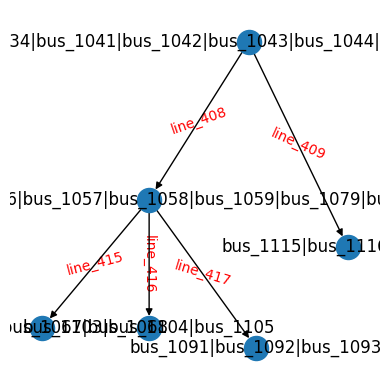

In [12]:
net_files = [os.path.join(FILE_PATHS["net_files"], "circuit3")]
self_resistances, self_reactances, mutual_reactances, nodelist, edgelist = \
    load_topology_parameters(net_files, remove_edges=["line_407"], plot=True)

In [13]:
# Build circuit dynamical model
edgelist_sorted = ['line_408', 'line_415', 'line_416', 'line_417', 'line_409']
R_matrices, L_matrices = {}, {}
for i, line in enumerate(edgelist_sorted):
    idx = edgelist.index(line)
    R = np.zeros((3,3))
    L = np.zeros((3,3))
    np.fill_diagonal(R, self_resistances[idx])
    np.fill_diagonal(L, self_reactances[idx])
    L[0,1] = L[1,0] = mutual_reactances[idx][0]
    L[1,2] = L[2,1] = mutual_reactances[idx][1]
    L[0,2] = L[2,0] = mutual_reactances[idx][2]
    R_matrices[f'R{i+1}'] = R
    L_matrices[f'L{i+1}'] = L

Z = np.zeros((3,3)) # 3 × 3 zero matrix
I = np.eye(3)       # identity matrix
R1 =  R_matrices['R1']
R2 =  R_matrices['R2']
R3 =  R_matrices['R3']
R4 =  R_matrices['R4']
R5 =  R_matrices['R5']
L1_ = np.linalg.inv(L_matrices['L1'])
L2_ = np.linalg.inv(L_matrices['L2'])
L3_ = np.linalg.inv(L_matrices['L3'])
L4_ = np.linalg.inv(L_matrices['L4'])
L5_ = np.linalg.inv(L_matrices['L5'])
A = np.block([[-L1_@R1, Z, Z, Z, Z],
              [Z, -L2_@R2, Z, Z, Z],
              [Z, Z, -L3_@R3, Z, Z],
              [Z, Z, Z, -L4_@R4, Z],
              [Z, Z, Z, Z, -L5_@R5]])
B = np.block([[L1_, -L1_, Z, Z, Z, Z],
              [Z, L2_, -L2_, Z, Z, Z],
              [Z, L3_, Z, -L3_, Z, Z],
              [Z, L4_, Z, Z, -L4_, Z],
              [L5_, Z, Z, Z, Z, -L5_]])
C = np.zeros((1,15))
D = np.zeros((1,18))

H1 = np.zeros((7*3, 5*3))
H2 = np.block([[np.eye(6*3, 6*3)],
               [np.zeros((1*3, 6*3))]])
H3 = np.block([[np.zeros((6*3, 6*3))],
               [np.eye(1*3, 1*3), np.zeros((1*3, 5*3))]])
H = np.block([[H1, H2, H3]])

C_hat_T = np.block([[I, Z, Z, Z, I],
                [I,-I,-I,-I, Z],
                [Z, I, Z, Z, Z],
                [Z, Z, I, Z, Z],
                [Z, Z, Z, I, Z],
                [Z, Z, Z, Z, I]])

gamma = np.array([[1, -1, 0],
                  [0, 1, -1],
                  [-1, 0, 1]])

path_waveforms = '../sample_dataset/waveforms'
timestamp = '2024-12-03T00:00:00'
load_files = [
    "egauge_21-L1", "egauge_21-L2", "egauge_21-L3",
    "egauge_17-S1", "egauge_17-S2", "egauge_17-S3",
    "egauge_11-S1", "egauge_11-S2", "egauge_11-S3",
    "egauge_3-S1", "egauge_3-S2", "egauge_3-S3",
    "egauge_13-S1", "egauge_13-S2", "egauge_13-S3",
    "egauge_7-S1", "egauge_7-S2", "egauge_7-S3",
    "egauge_9-S1", "egauge_9-S2", "egauge_9-S3"
]
result = utils.load_waveforms(path_waveforms, timestamp, load_files)
result_aligned = utils.resample_waveforms(result)
data_aligned = result_aligned[list(result_aligned.keys())[0]]

## Data pre-processing: map across transformers
We eliminate transformer in the circuit and conduct state estimation on the 2.4kV level only. For measurement at the 16.5kV and 480V levels, we map them across the transformer to obtain the current and voltage at the 2.4kV level.

In [14]:
# High voltage transformer: V_delta → V_y, aligned I
delta_keys = ["egauge_21-L1", "egauge_21-L2", "egauge_21-L3"]
y_keys = ["egauge_17-S2", "egauge_17-S3", "egauge_17-S1"]
y_u_keys = ["egauge_17-L1", "egauge_17-L2", "egauge_17-L3"]
aligned_dfs_v = {k: data_aligned[k] for k in delta_keys}
aligned_dfs_v = p2l(aligned_dfs_v, delta_keys)
aligned_dfs_i = {k: data_aligned[k] for k in y_keys}
new_dfs_v = delta2y(aligned_dfs_v, aligned_dfs_i, delta_keys, y_keys, y_u_keys)
for key in data_aligned:
    data_aligned[key] = data_aligned[key].iloc[1:].reset_index(drop=True)
new_dfs_1 = {k: data_aligned[k] for k in y_keys}

# Low voltage transformer: I_y → I_delta
data_aligned['egauge_13-S1'], data_aligned['egauge_13-S3'] = (
    data_aligned['egauge_13-S3'],
    data_aligned['egauge_13-S1']
)

y_keys_2 = ["egauge_9-S1", "egauge_9-S2", "egauge_9-S3"]
aligned_dfs_i = {k: data_aligned[k] for k in y_keys_2}
new_dfs_2 = y2delta(aligned_dfs_i, y_keys_2)
y_keys_3 = ["egauge_11-S1", "egauge_11-S2", "egauge_11-S3"]
aligned_dfs_i = {k: data_aligned[k] for k in y_keys_3}
new_dfs_3 = y2delta(aligned_dfs_i, y_keys_3)
y_keys_4 = ["egauge_3-S1", "egauge_3-S2", "egauge_3-S3"]
aligned_dfs_i = {k: data_aligned[k] for k in y_keys_4}
new_dfs_4 = y2delta(aligned_dfs_i, y_keys_4)
y_keys_5 = ["egauge_13-S1", "egauge_13-S2", "egauge_13-S3"]
aligned_dfs_i = {k: data_aligned[k] for k in y_keys_5}
new_dfs_5 = y2delta(aligned_dfs_i, y_keys_5)
y_keys_6 = ["egauge_7-S1", "egauge_7-S2", "egauge_7-S3"]
aligned_dfs_i = {k: data_aligned[k] for k in y_keys_6}
new_dfs_6 = y2delta(aligned_dfs_i, y_keys_6)

# Measurement vectors: [line_408 current, 5 leaf nodes' current, slackbus-V]
mea_dicts = [new_dfs_1, new_dfs_2, new_dfs_3, new_dfs_4, new_dfs_5, new_dfs_6, new_dfs_v]
# Extract partial data for running time-domain state estimation
def construct_mea_vector(mea_dicts, N):
    """
    Extract the first N rows from each dataframe in a list of dictionaries and construct a consolidated dataframe
    :param mea_dicts: list of dictionary, each dictionary contains dataframes keyed by egauge names
    :param N: positive integer, the number of rows to extract (if N exceeds dataframe length, it uses the maximum available rows)
    :return: 
        - time_col: numpy.ndarray, time column from the first dataframe in the first dictionary
        - mea_data: numpy.ndarray, (number_of_measurement_points, N) consolidated data from all dataframes in the list
    """
    first_key, first_df = next(iter(mea_dicts[0].items()))
    max_rows = min(N,len(first_df))
    partial_mea_dicts = []
    for mea_dict in mea_dicts:
        partial_dict = {key: df.iloc[:max_rows] for key, df in mea_dict.items()}
        partial_mea_dicts.append(partial_dict)
        
    time_col = next(iter(partial_mea_dicts[0].values()))['t']
    vector = []
    for d in partial_mea_dicts:
        for key in sorted(d.keys()):
            vector.append(d[key]['v'])
        
    return np.array(time_col), np.stack(vector)

time_col, mea_data = construct_mea_vector(mea_dicts, 329)

Current operable rows for time-domain state estimation: 329


## Formulate regression problem

In [15]:
# Optimization: Least squares regression
T = len(time_col)
i_l = cp.Variable((15,T))
i_b = cp.Variable((18,T))
v_b = cp.Variable((18,T))

objective = cp.norm(mea_data - H @ cp.vstack([i_l, i_b, v_b]), 2)

constraints = []
previous_time = np.nan
for t in range(T):
    if t == 0:
        previous_time = time_col[t]
    else:
        current_time = time_col[t]
        dt = (current_time - previous_time) / ONE_SEC
        previous_time = current_time
        A_d, B_d, Cd, Dd = discretization(A, B, C, D, dt) 
        constraints.append(i_l[:,t] == A_d @ i_l[:,t-1] + B_d @ v_b[:,t-1])
constraints.append(i_b == C_hat_T @ i_l)

problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()


253.9401262033446

## Plotting

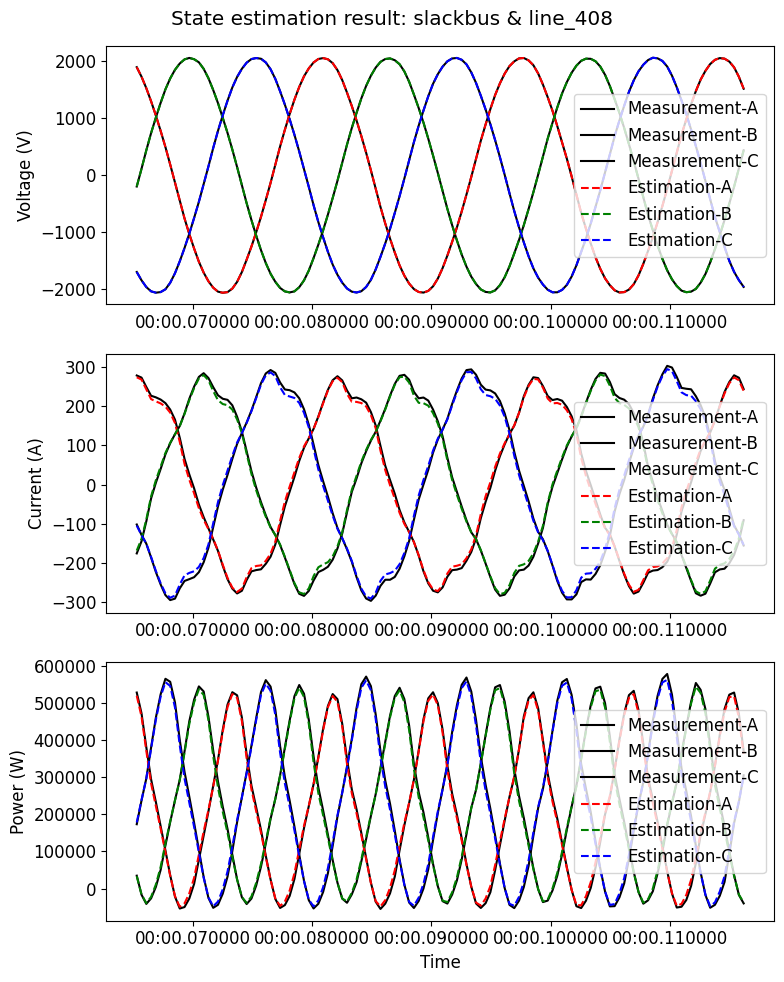

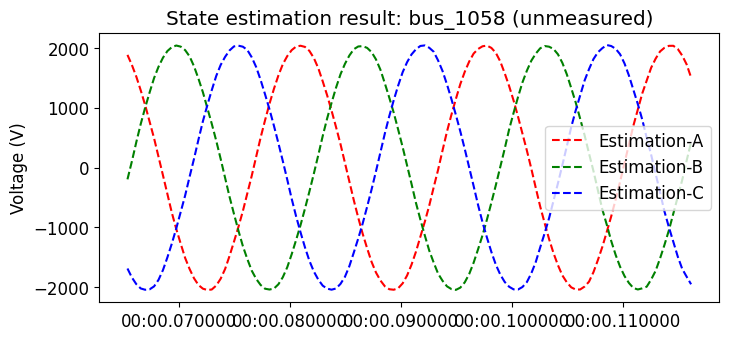

In [20]:

fig, axs = plt.subplots(3, figsize=(8, 10))
plt.rcParams.update({'font.size': 12})
N = 128     # number of time samples to plot

def plot_results(t, result, measurement=None, phases='ABCN', ax=None, figsize=(8, 3.5), ylabel="", title=''):
    c = ['r', 'g', 'b', 'yellow']
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    if measurement is not None:
        for i, p in enumerate(phases[:len(measurement)]):
            ax.plot(t, measurement[i], linestyle='-', color='black', label=f"Measurement-{p}")
    for i, p in enumerate(phases[:len(result)]):
        ax.plot(t, result[i], linestyle='--', color=c[i], label=f"Estimation-{p}")
    ax.set_ylabel(ylabel)
    ax.legend(loc='center right')
    ax.set_title(title)

# Voltage (slack bus)
t = time_col[:N]
v_result = np.stack([v_b.value[i, :T] for i in [0, 1, 2]])[:,:N]
v_measurement = np.stack([mea_data[i] for i in [18, 19, 20]])[:,:N]
plot_results(t, v_result, v_measurement, ylabel="Voltage (V)", ax=axs[0])
# Current (line 408)
i_result = np.stack([i_l.value[i, :T] for i in [0, 1, 2]])[:,:N]
i_measurement = np.stack([mea_data[i] - mea_data[j] for i, j in [(0, 15), (1, 16), (2, 17)]])[:,:N]
plot_results(t, i_result, i_measurement, ylabel="Current (A)", ax=axs[1])
# Power
s_result = v_result * i_result
s_measurement = v_measurement * i_measurement
plot_results(t, s_result, s_measurement, ylabel="Power (W)", ax=axs[2])

plt.xlabel("Time")
fig.suptitle("State estimation result: slackbus & line_408")
fig.tight_layout()
fig.show()

# Plot a unmeasured bus
v_result = np.stack([v_b.value[i] for i in [3, 4, 5]])[:,:N]
plot_results(t, v_result, ylabel="Voltage (V)", title="State estimation result: bus_1058 (unmeasured)")

In [29]:
# % RMS error for all measured nodes
estimation = H @ np.concatenate([i_l.value, i_b.value, v_b.value], axis=0)
error = mea_data - estimation

rms = np.sqrt((mea_data**2).mean(axis=1))
rms_error = np.sqrt((error**2).mean(axis=1)) / rms
print("Overall RMS error:", rms_error.mean())
print("RMS error for each node:")
labels = ['slackbus injection', 'line_408', 'line_415', 'line_416', 'line_417', 'line_409', 'bus_1034']
t = time_col[:N]
for i in range(7):
    # plot_results(t, estimation[i*3:(i+1)*3, :N], mea_data[i*3:(i+1)*3, :N], title=labels[i])
    print(f"{labels[i]} % rms error: {rms_error[i*3:i*3+3]*100} (%)")

Overall RMS error: 0.13139780319850836
RMS error for each node:
slackbus injection % rms error: [1.44 1.24 1.57] (%)
line_408 % rms error: [5.14 4.33 5.63] (%)
line_415 % rms error: [6.96 6.15 7.4 ] (%)
line_416 % rms error: [55.64 62.21 73.79] (%)
line_417 % rms error: [10.48  9.15 11.73] (%)
line_409 % rms error: [4.32 3.77 4.97] (%)
bus_1034 % rms error: [0. 0. 0.] (%)
